# Thermal Scattering



In emission geometries (secondary eclipse, direct emission), directional scattering becomes important. 

For this notebook, we will take a look at how scattering affects the spectra of a directly imaged Y-dwarf, and the emission spectra of a hot jupiter. 

We have implemented the Toon scattering from PICASO (https://arxiv.org/pdf/1904.09355), see (https://natashabatalha.github.io/picaso_dev), into POSEIDON. 

If thermal scattering is used, please cite both Batalha 2019 and Mullens 2024. 

In order to utilize this feature, set scattering=True into forward model. 

For more details of the actual code, see emission_Toon() in emission.py in POSEIDON, and get_thermal_1d() in fluxes.py in PICASO.

<img src="../../_static/notebook_images/Emission-cloud-effect.png" />

## Hot Jupiter Scattering

In emission geometries, aerosols can impart scattering features even if the atmosphere is isothermal. We will be using HD 189733b as an example of this.

In [5]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          wl_grid_constant_R, read_opacities

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

#***** Model wavelength grid *****#

wl_min = 0.5      # Minimum wavelength (um)
wl_max = 20       # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
#d_err = 0.005*pc # Error in a priori system distance
a_p = 0.03142*au

# Create the planet object
# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)


#***** Define stellar properties *****#

R_s = 0.78*R_Sun      # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

model_name = 'Scattering-Features'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['MgSiO3']

# Create the model object
model_scat = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm',
                     cloud_model = 'Mie',cloud_type = 'slab',
                     aerosol_species = aerosol_species,
                     scattering = True)

model_no_scat = define_model(model_name, bulk_species, param_species, 
                    PT_profile = 'isotherm',
                    cloud_model = 'Mie',cloud_type = 'slab',
                    aerosol_species = aerosol_species,
                    scattering = False)

Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


In [2]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100    # Same as prior range for T
T_fine_max = 3000    # Same as prior range for T
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#
opac = read_opacities(model_scat, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Opacity pre-interpolation complete.


In [17]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J
T = 1200

log_CO                =   -5.30 
log_CO2               =   -3.07 
log_H2O               =   -5.33  

log_P_top_slab_MgSiO3 =   -1
Delta_log_P_MgSiO3    =   4
log_r_m_MgSiO3        =   0
log_X_MgSiO3          =   -10

PT_params = np.array([T])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere= make_atmosphere(planet, model_scat, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params)

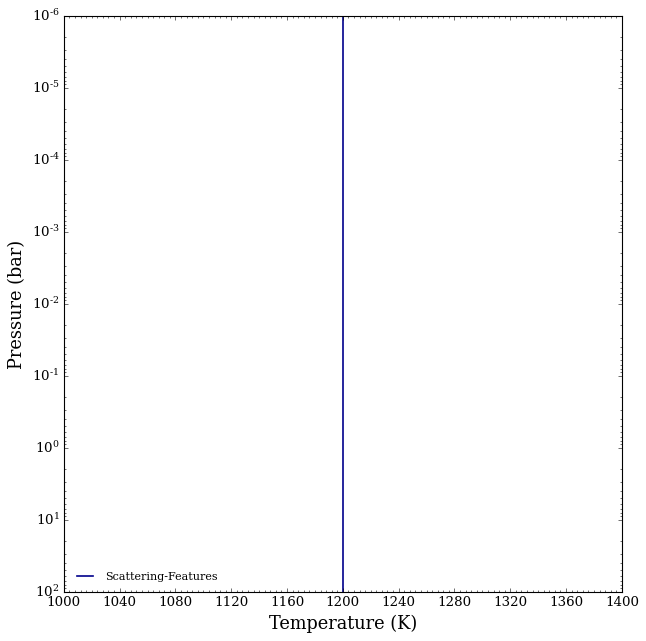

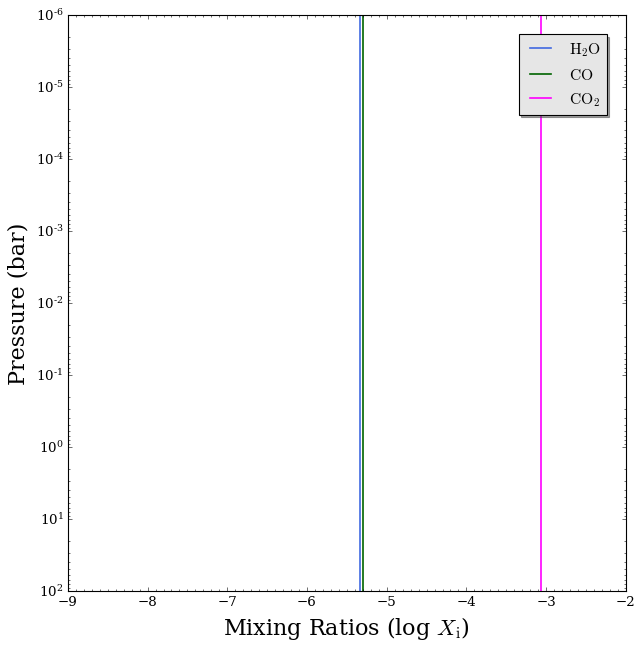

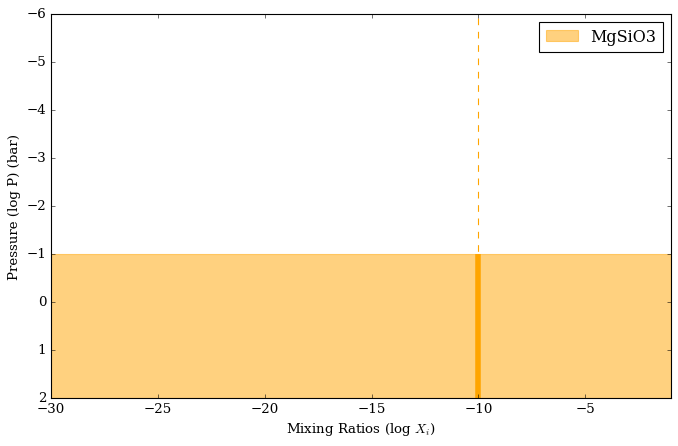

In [18]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_no_scat, atmosphere)


fig_chem = plot_chem(planet, model_no_scat, atmosphere, 
                     plot_species = ['H2O', 'CO', 'CO2'],
                     log_X_min = -9, log_P_max = 2.0)


from POSEIDON.clouds import plot_clouds

plot_clouds(planet,model_scat,atmosphere)

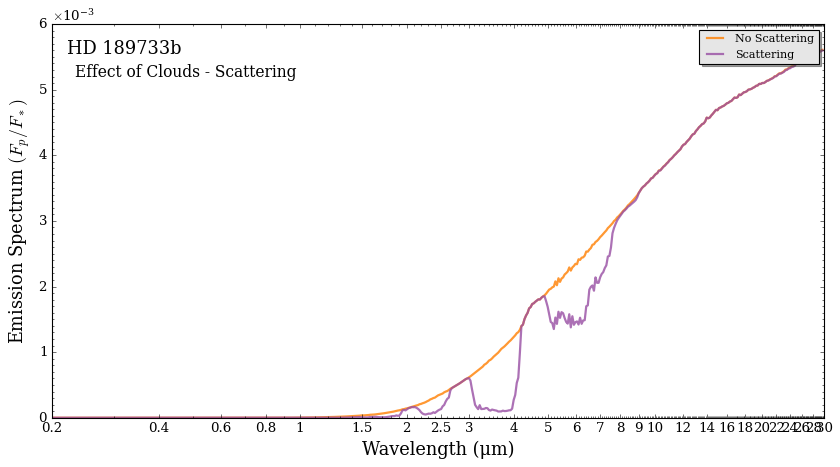

In [19]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scat, atmosphere, opac, wl, 
                              spectrum_type = 'emission', save_spectrum = True)
Fp_Fs_scat = compute_spectrum(planet, star, model_scat, atmosphere, opac, wl, 
                           spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['No Scattering', 'Scattering'],
                        legend_location = 'upper right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title,
                        figure_shape = 'wide')

As we can see above, even in isothermal environments, aerosols can impart scattering features that will cause the spectrum to deviate from a blackbody.

Reading in database for aerosol cross sections...


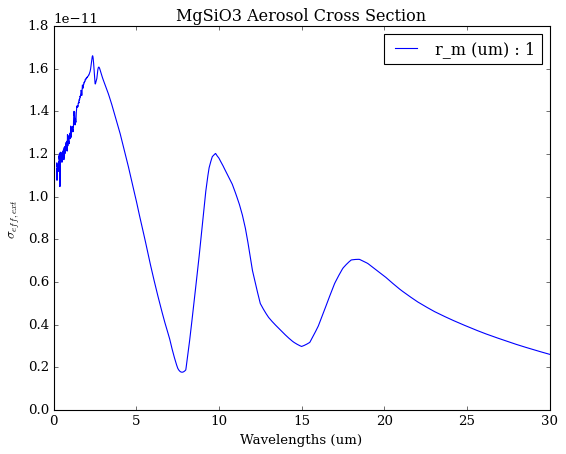

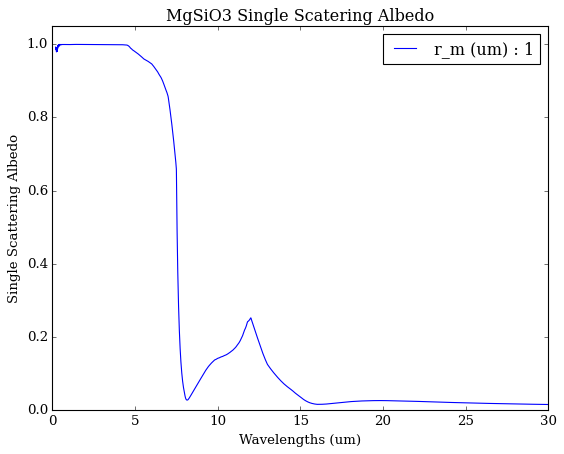

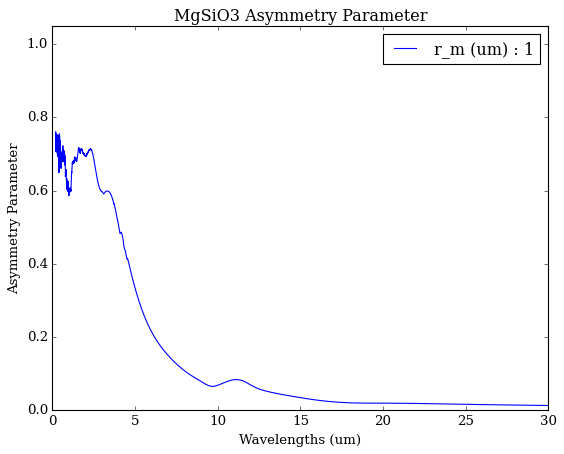

In [20]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'MgSiO3'

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Test to see if the cross sections come out with SiO2 particle, 0.01 um sized
r_m = 1

# This formula loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

label = 'r_m (um) : ' + str(r_m)
title = 'MgSiO$_3$ Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.show()

title = 'MgSiO$_3$ Single Scatering Albedo'

plt.plot(wl,eff_w, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Single Scattering Albedo')
plt.ylim((0,1.05))
plt.show()

title = 'MgSiO$_3$ Asymmetry Parameter'

plt.plot(wl,eff_g, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Asymmetry Parameter')
plt.ylim((0,1.05))
plt.show()